In [28]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cp /content/drive/MyDrive/Healthcare+AI+Datasets.zip /content
# !unzip Healthcare+AI+Datasets.zip
# %cd Healthcare AI Datasets/Brain_MRI

In [29]:
import pandas as pd
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage import io
from utilities import DataGenerator
from utilities import focal_tversky, tversky_loss, tversky
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add
from tensorflow.keras.layers import UpSampling2D, Concatenate, MaxPool2D, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [30]:
# data containing path to Brain MRI and their corresponding mask
brain_df = pd.read_csv('data_mask.csv')
brain_df.head(3)

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0


In [31]:
brain_df.shape

(3929, 4)

In [32]:
brain_df['mask'].value_counts(normalize=True)

0    0.650547
1    0.349453
Name: mask, dtype: float64

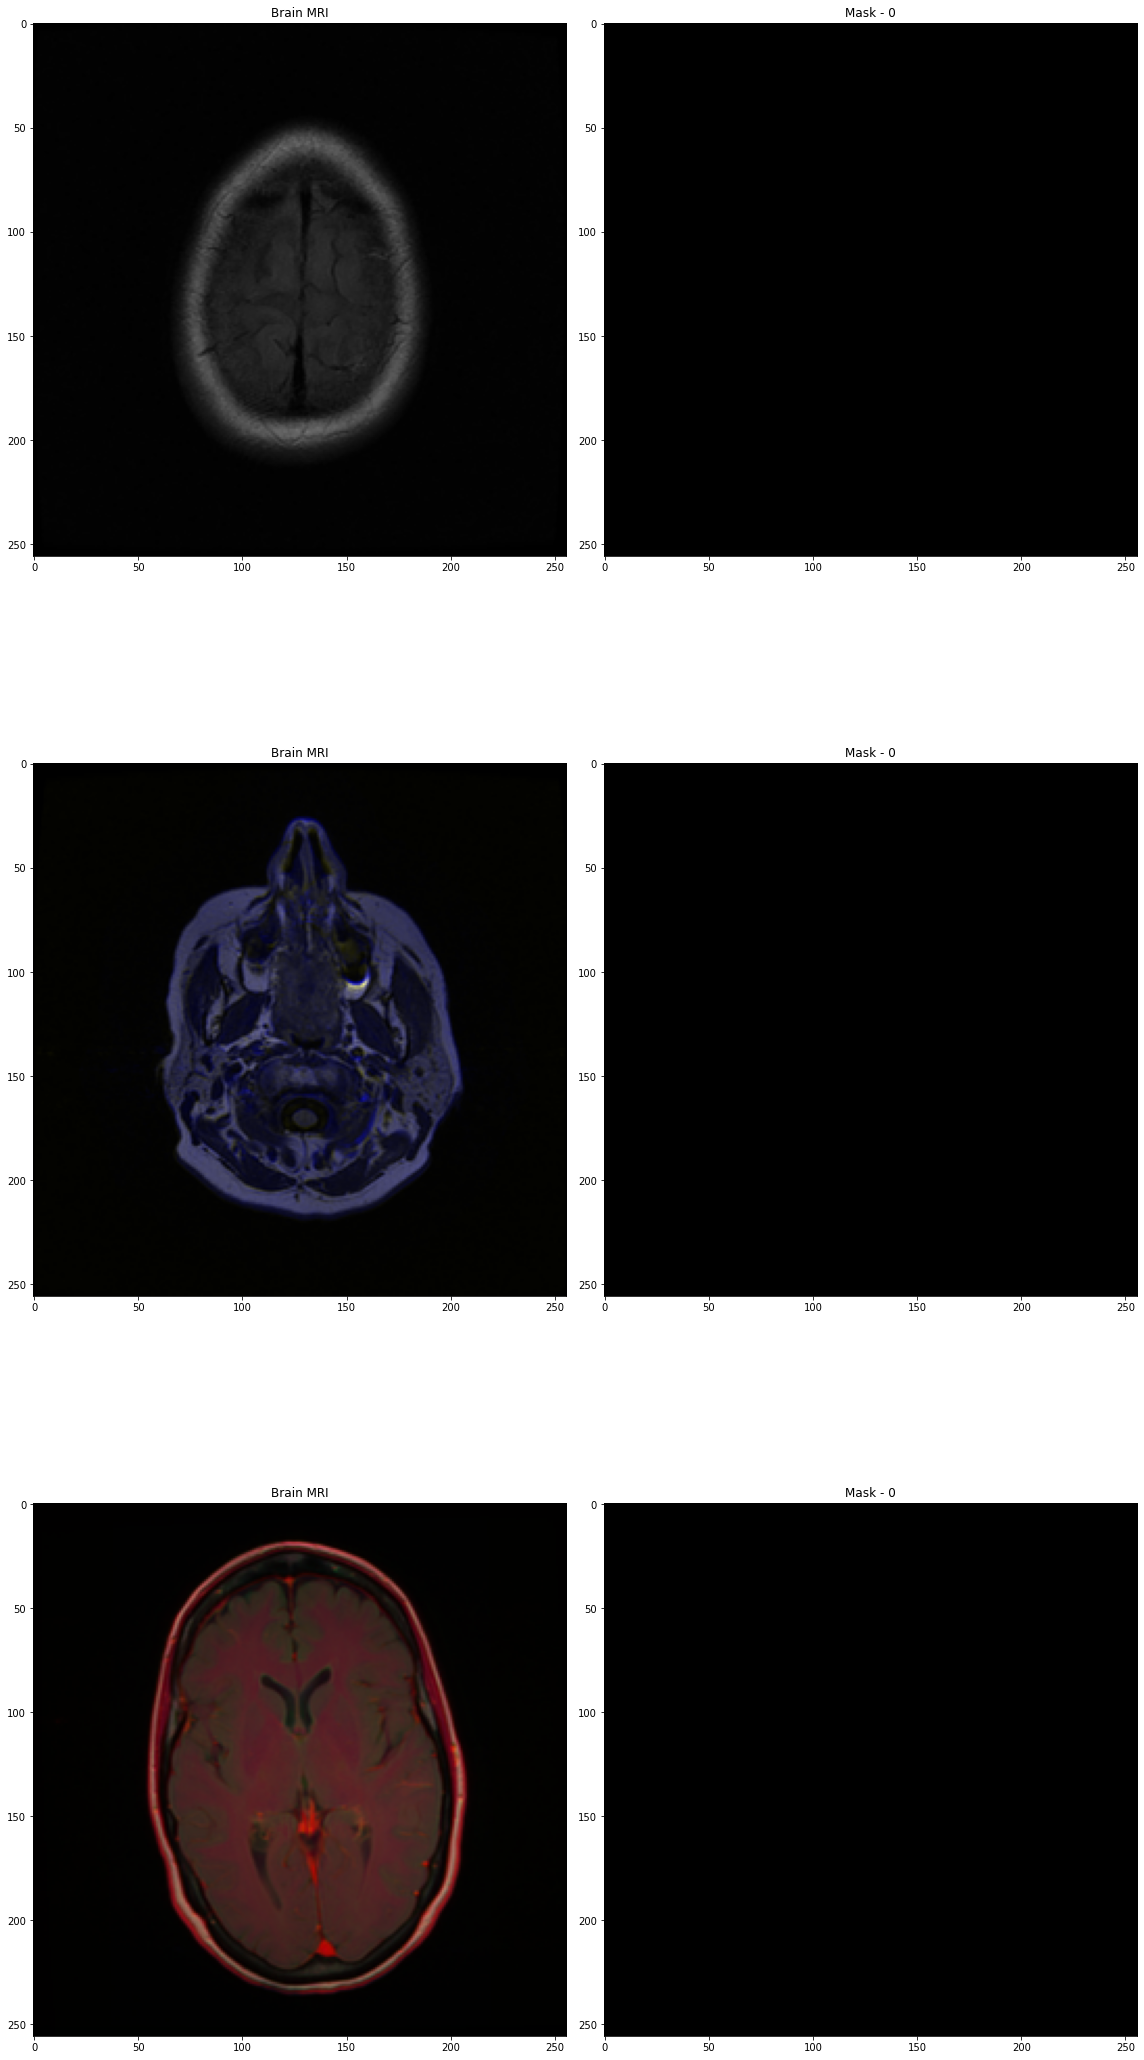

In [33]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately 
n_row = 3
n_col = 2
fig, axs = plt.subplots(n_row,n_col, figsize=(16,32))

for count in range(n_row):
    i = random.randint(0, brain_df.shape[0])                              # select a random index
    axs[count][0].title.set_text("Brain MRI")                             # set title
    axs[count][0].imshow(cv2.imread(brain_df['image_path'][i]))           # show MRI 
    axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i]))    # plot title on the mask (0 or 1)
    axs[count][1].imshow(cv2.imread(brain_df['mask_path'][i]))            # Show corresponding mask

fig.tight_layout()

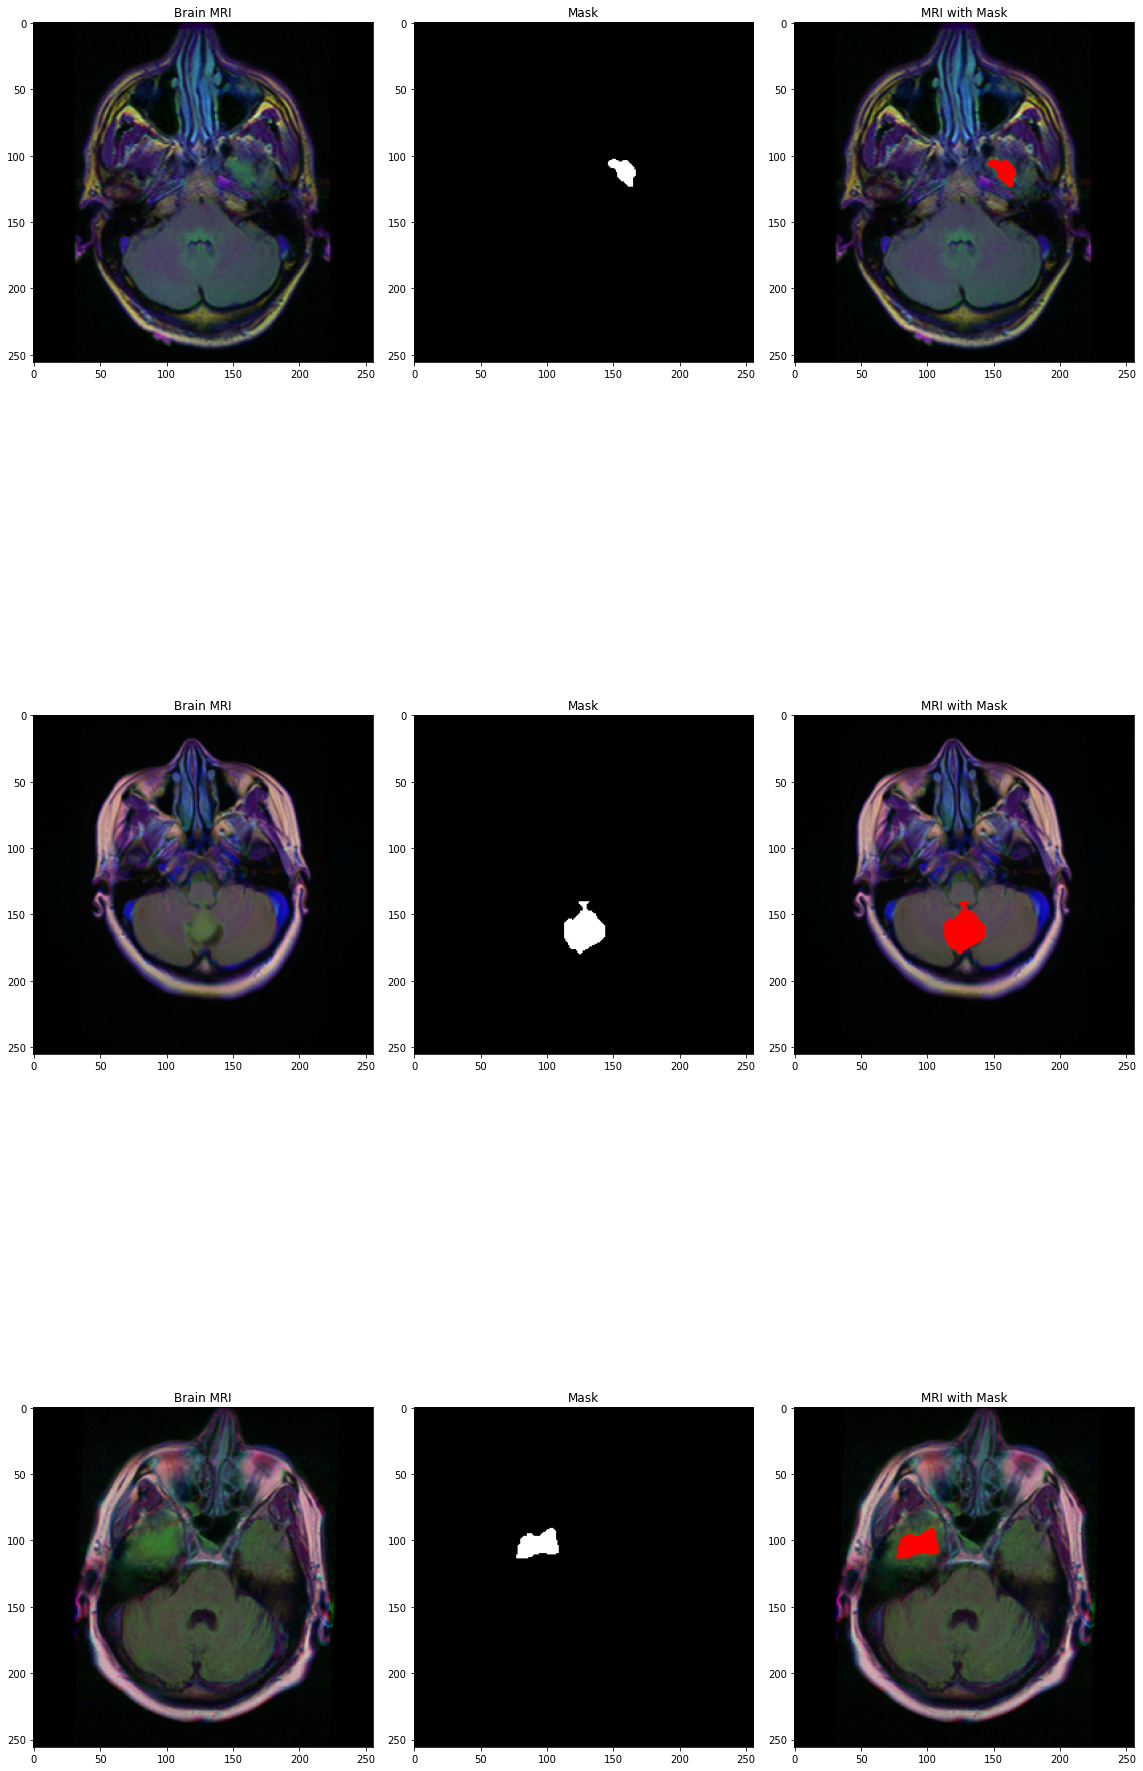

In [34]:
n_row = 3
n_col = 3

fig, axs = plt.subplots(n_row,n_col, figsize=(16,32))
only_mask = brain_df[brain_df['mask'] == 1]
index = 0

for count in range(n_row):

    # plot MRI
    img = io.imread(only_mask['image_path'].values[index])
    axs[count][0].title.set_text("Brain MRI")                             
    axs[count][0].imshow(img)         
    
    # Plot Mask
    mask =  io.imread(only_mask['mask_path'].values[index])
    axs[count][1].title.set_text("Mask")  
    axs[count][1].imshow(mask,cmap='gray')

    # overlap MRI and Mask
    img[mask==255] = (255,0,0)
    axs[count][2].title.set_text('MRI with Mask')
    axs[count][2].imshow(img) 

    index = index + 1

fig.tight_layout()


In [35]:
# split the data into train and test data
X_train, X_val = train_test_split(brain_df, test_size=0.20,stratify=brain_df['mask'])
X_test, X_val = train_test_split(X_val, test_size=0.5,stratify=X_val['mask'])

In [36]:
# create separate list for imageId, classId to pass into the generator

train_ids = list(X_train['image_path'])
train_mask = list(X_train['mask_path'])

val_ids = list(X_val['image_path'])
val_mask= list(X_val['mask_path'])

In [37]:
# Utilities file contains the code for custom loss function and custom data generator
# create image generators

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [38]:
def resblock(X, f):
  
  # make a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [39]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [40]:
## ResUNET Architecture

input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )

In [41]:
model_seg.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 256, 256, 16) 64          conv2d_27[0][0]                  
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 256, 256, 16) 2320        batch_normalization_26[0][0]     
_______________________________________________________________________________________

In [42]:
# We need a custom loss function to train this ResUNet.
# we have used the loss function as it is from https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py

# Compile the model
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [43]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

In [44]:
history = model_seg.fit(training_generator, epochs = 20, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

/content/Healthcare AI Datasets/Brain_MRI/utilities.py:92: RuntimeWarning: invalid value encountered in true_divide
  mask /= mask.std()
/content/Healthcare AI Datasets/Brain_MRI/utilities.py:101: RuntimeWarning: invalid value encountered in greater
  y = (y > 0).astype(np.float32)


Epoch 1/20
196/196 [==============================] - ETA: 0s - loss: 0.9577 - tversky: 0.0560
Epoch 00001: val_loss improved from inf to 0.94716, saving model to ResUNet-weights.hdf5
196/196 [==============================] - 38s 194ms/step - loss: 0.9577 - tversky: 0.0560 - val_loss: 0.9472 - val_tversky: 0.0697
Epoch 2/20
196/196 [==============================] - ETA: 0s - loss: 0.7490 - tversky: 0.3107
Epoch 00002: val_loss improved from 0.94716 to 0.86189, saving model to ResUNet-weights.hdf5
196/196 [==============================] - 36s 185ms/step - loss: 0.7490 - tversky: 0.3107 - val_loss: 0.8619 - val_tversky: 0.1791
Epoch 3/20
196/196 [==============================] - ETA: 0s - loss: 0.4988 - tversky: 0.5962
Epoch 00003: val_loss improved from 0.86189 to 0.72301, saving model to ResUNet-weights.hdf5
196/196 [==============================] - 37s 186ms/step - loss: 0.4988 - tversky: 0.5962 - val_loss: 0.7230 - val_tversky: 0.3455
Epoch 4/20
196/196 [========================

In [45]:
# save the model architecture to json file for future use
model_json = model_seg.to_json()
with open("ResUNet-model.json","w") as json_file:
  json_file.write(model_json)

In [46]:
with open('ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture 
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [47]:
def prediction(test, model_seg):

  #directory
  directory = "./"

  #Creating empty list to store the results
  mask = []
  image_id = []
  has_mask = []

  #iterating through each image in the test data
  for i in test['image_path']:

    path = directory + str(i)

    #Read the image
    img = io.imread(path)

    #Creating a empty array of shape 1,256,256,1
    X = np.empty((1, 256, 256, 3))

    #resizing the image and coverting them to array of type float64
    img = cv2.resize(img,(256,256))
    img = np.array(img, dtype = np.float64)

    #standardising the image
    img -= img.mean()
    img /= img.std()

    #converting the shape of image from 256,256,3 to 1,256,256,3
    X[0,] = img

    #make prediction
    predict = model_seg.predict(X)

    #if the sum of predicted values is equal to 0 then there is no tumour
    if predict.round().astype(int).sum() == 0:
        image_id.append(i)
        has_mask.append(0)
        mask.append('No mask')
    else:
    #if the sum of pixel values are more than 0, then there is tumour
        image_id.append(i)
        has_mask.append(1)
        mask.append(predict)

  return image_id, mask, has_mask

In [48]:
# making prediction
image_id, mask, has_mask = prediction(X_test, model_seg)

In [49]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

,image_path,predicted_mask,has_mask
0,TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_14...,"[[[[4.5788065e-07], [1.5426982e-06], [2.881201...",1
1,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_19...,No mask,0
2,TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_1.tif,"[[[[4.916701e-07], [1.8169137e-06], [3.818424e...",1
3,TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_6.tif,"[[[[6.112126e-07], [2.110506e-06], [4.027198e-...",1
4,TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_22...,"[[[[7.487561e-07], [2.9636417e-06], [6.297748e...",1
...,...,...,...
388,TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_20...,"[[[[7.600934e-07], [2.5511436e-06], [4.763844e...",1
389,TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_9.tif,"[[[[6.4513347e-07], [2.1833146e-06], [4.044073...",1
390,TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_3.tif,"[[[[6.948592e-07], [2.646664e-06], [4.4855847e...",1
391,TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_21...,No mask,0


In [50]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = X_test.merge(df_pred, on = 'image_path')
df_pred.head()

,patient_id,image_path,mask_path,mask,predicted_mask,has_mask
0,TCGA_DU_7306_19930512,TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_14...,TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_14...,0,"[[[[4.5788065e-07], [1.5426982e-06], [2.881201...",1
1,TCGA_FG_6692_20020606,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_19...,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_19...,0,No mask,0
2,TCGA_CS_4944_20010208,TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_1.tif,TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_1_...,0,"[[[[4.916701e-07], [1.8169137e-06], [3.818424e...",1
3,TCGA_DU_5852_19950709,TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_6.tif,TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_6_...,0,"[[[[6.112126e-07], [2.110506e-06], [4.027198e-...",1
4,TCGA_FG_A4MT_20020212,TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_22...,TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_22...,1,"[[[[7.487561e-07], [2.9636417e-06], [6.297748e...",1


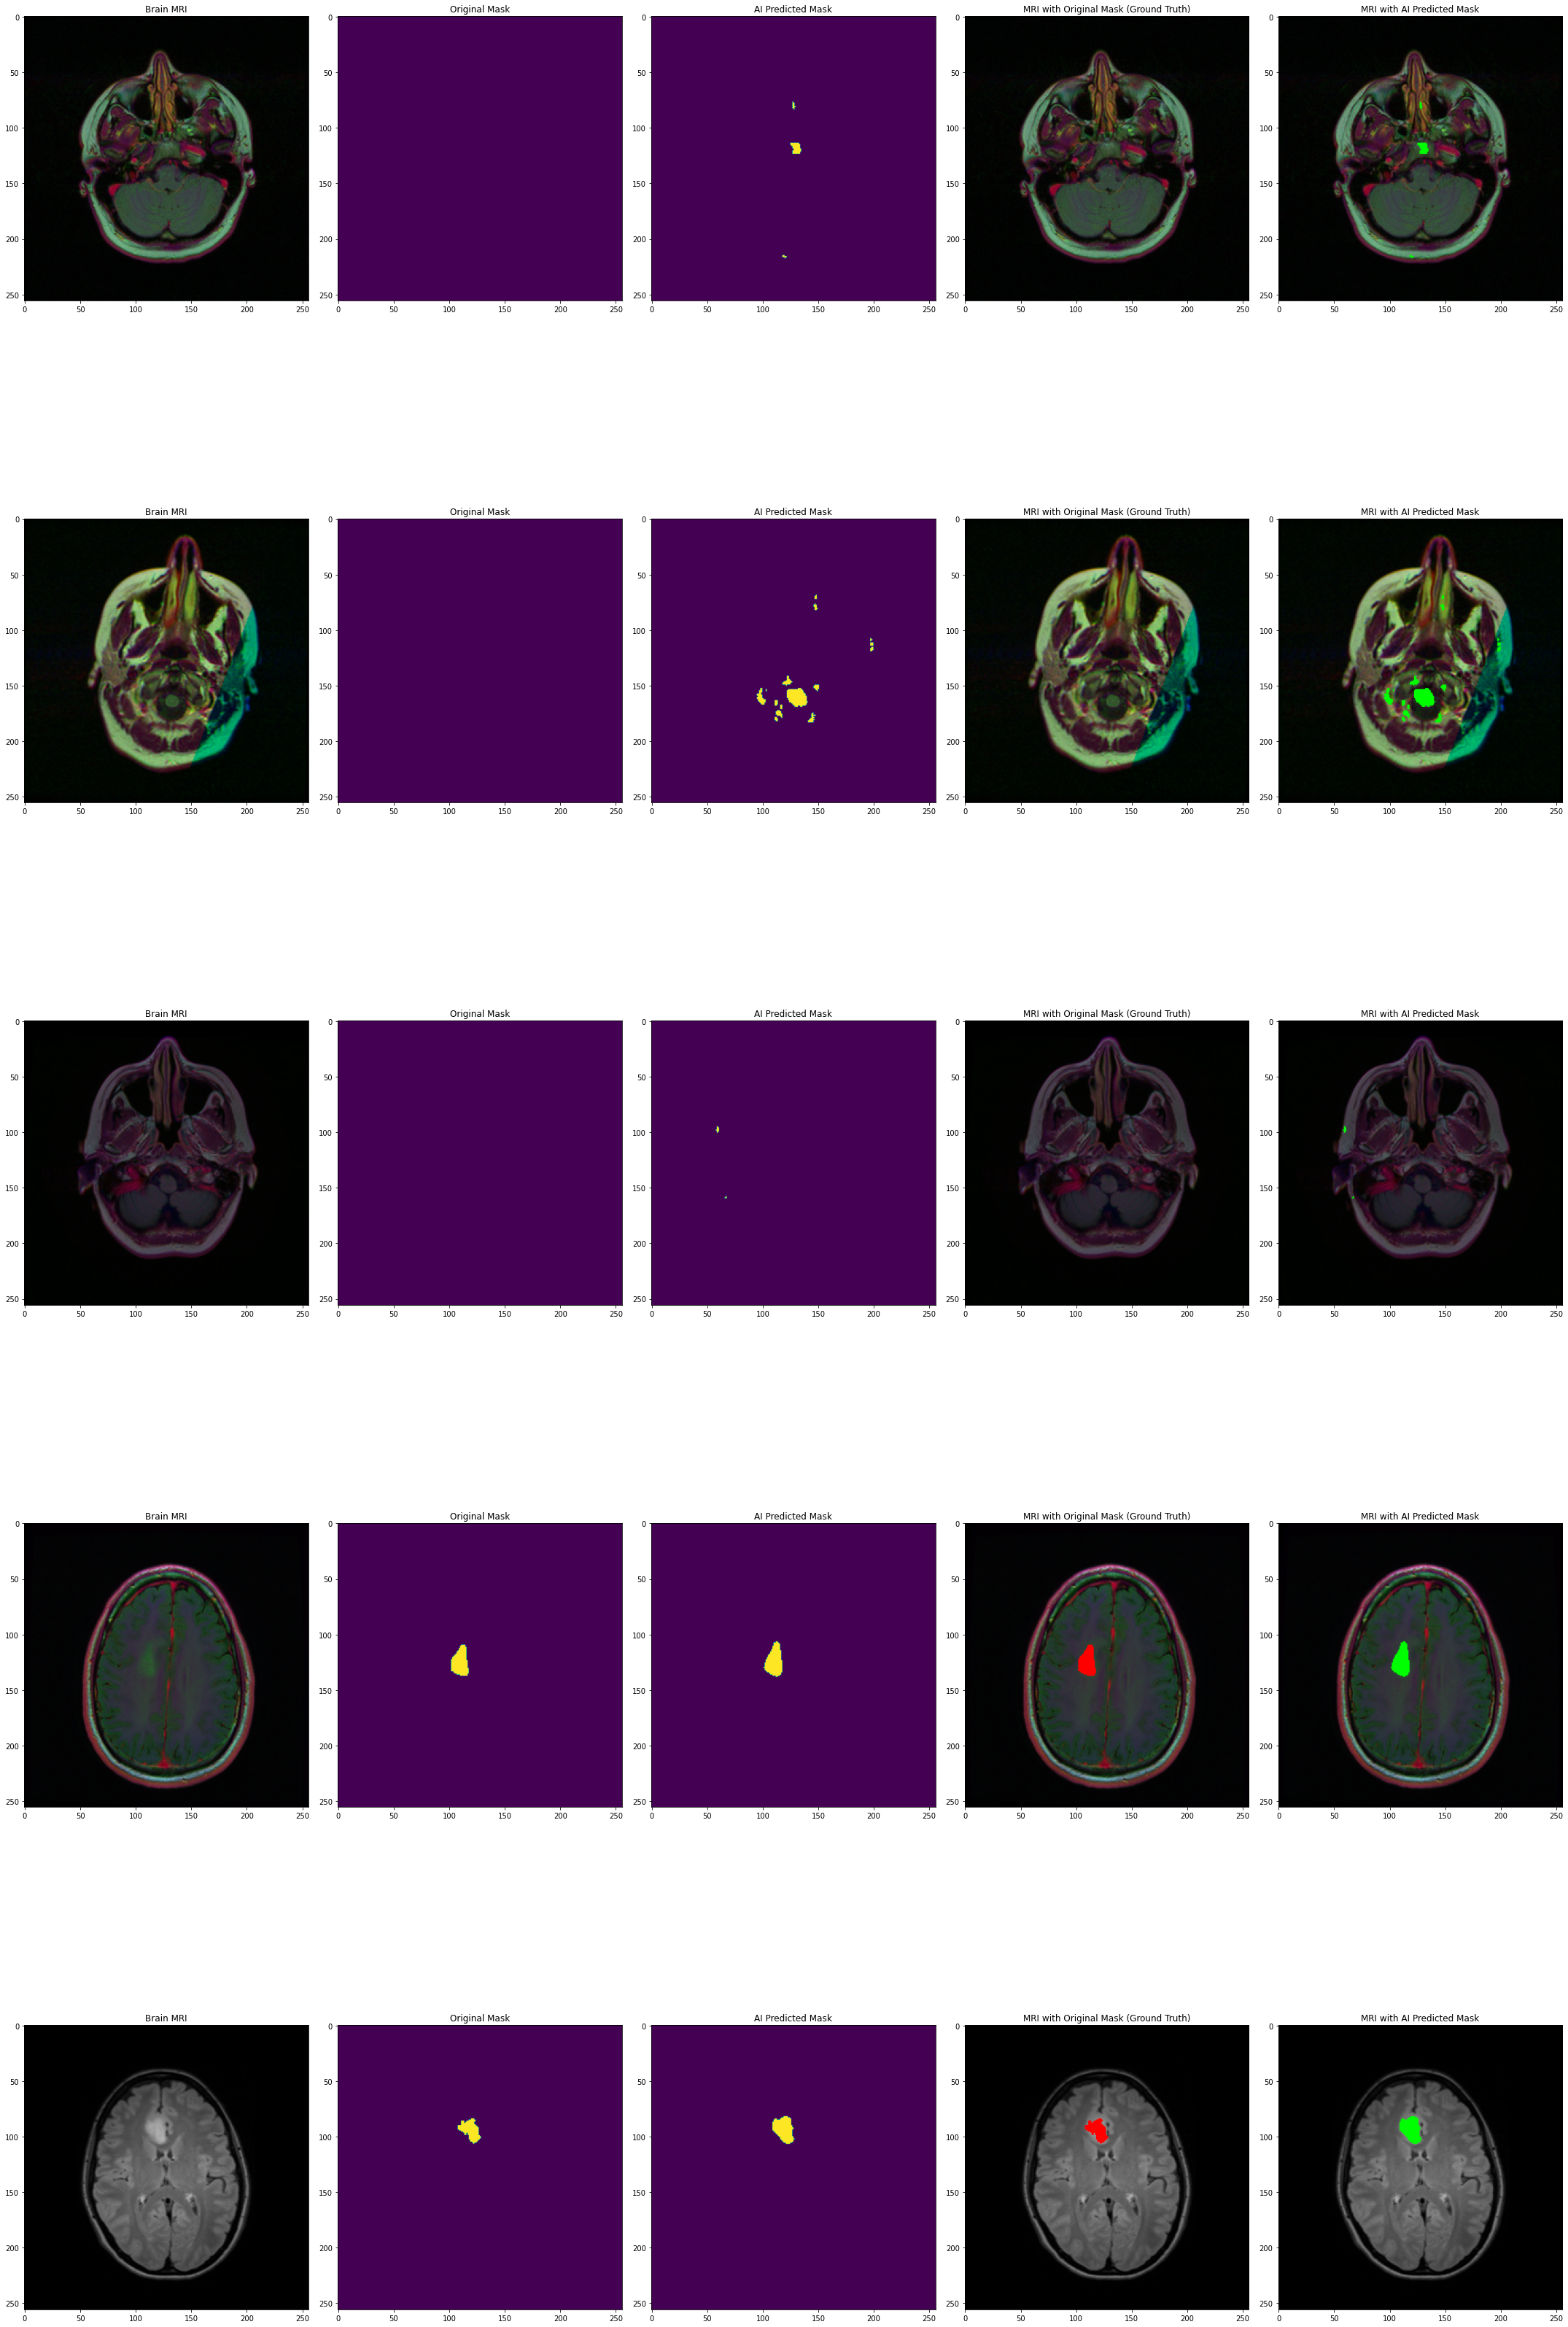

In [51]:
count = 0 
fig, axs = plt.subplots(5, 5, figsize=(30, 50))

for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 5:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()